<a href="https://colab.research.google.com/github/Pensom19/luna/blob/one/poy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyxdf matplotlib numpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyedflib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 19.4 MB/s eta 0:00:00


In [ ]:
# แสดงชื่อของทุก stream ในไฟล์ XDF
for i, stream in enumerate(streams):
    print(f"Stream {i}: {stream['info']['name'][0]}")


Stream 0: openvibeMarkers
Stream 1: openvibeSignal
Stream 2: eeg
Stream 3: openvibeMarkers
Stream 4: PsychoPyMarkers


In [ ]:
eeg_stream = next(stream for stream in data if stream['info']['name'][0] == 'PsychoPyMarkers')

In [ ]:
!pip install pyxdf

In [ ]:
!pip install pyxdf scipy matplotlib numpy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


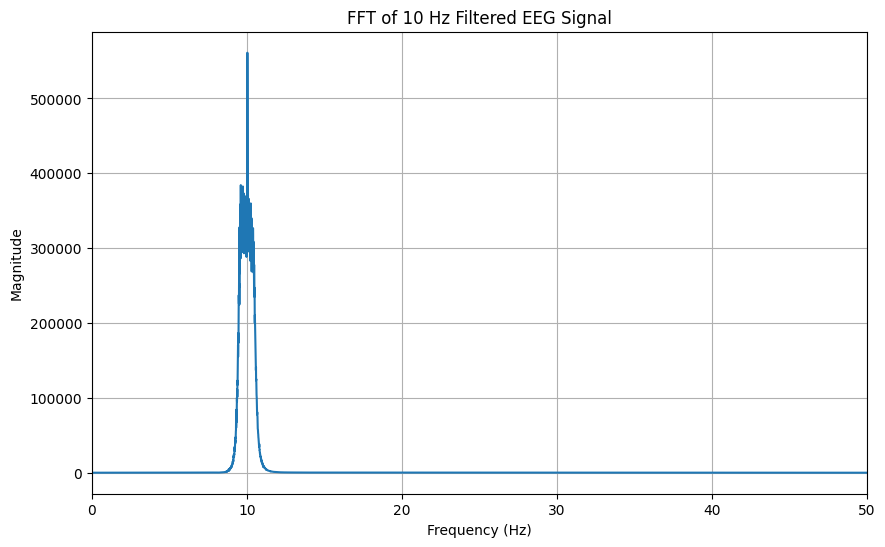

In [ ]:
import pyxdf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Step 3: ฟังก์ชันสำหรับกรองสัญญาณ
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Step 4: โหลดไฟล์ XDF จาก Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/sub-testttt_ses-gfdgfdgdfgfdgfdgfdg_task-Default_run-001_eeg.xdf'  # แก้ไขตำแหน่งไฟล์ที่อยู่ใน Google Drive
streams, header = pyxdf.load_xdf(file_path)

# เลือก stream ที่เป็น EEG (สามารถปรับได้ตามโครงสร้างข้อมูลของคุณ)
eeg_stream = next(stream for stream in streams if stream['info']['name'][0] == 'openvibeSignal')

# ดึงสัญญาณ EEG
eeg_data = np.array(eeg_stream['time_series'])
eeg_fs = int(eeg_stream['info']['nominal_srate'][0])  # Sample rate

# Step 5: กรองสัญญาณที่ 10 Hz
filtered_eeg = bandpass_filter(eeg_data.T, 9.5, 10.5, eeg_fs)  # กรองรอบ 10 Hz

# Step 6: คำนวณ FFT สำหรับการวิเคราะห์ความถี่
def compute_fft(signal, fs):
    n = len(signal)
    freqs = np.fft.fftfreq(n, 1/fs)
    fft_values = np.fft.fft(signal)
    magnitude = np.abs(fft_values)
    return freqs[:n//2], magnitude[:n//2]  # Return เฉพาะครึ่งแรกของความถี่ที่เป็นบวก

# เลือก channel ที่ต้องการ (ในที่นี้ใช้ channel แรกเป็นตัวอย่าง)
channel_data = filtered_eeg[0]  # channel 0

# คำนวณ FFT
freqs, magnitude = compute_fft(channel_data, eeg_fs)

# Step 7: แสดงผลกราฟ
plt.figure(figsize=(10, 6))
plt.plot(freqs, magnitude)
plt.xlim(0, 50)  # จำกัดช่วงความถี่ที่แสดงผล (เช่น 0-50 Hz)
plt.title('FFT of 10 Hz Filtered EEG Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

In [ ]:
!pip install pyxdf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


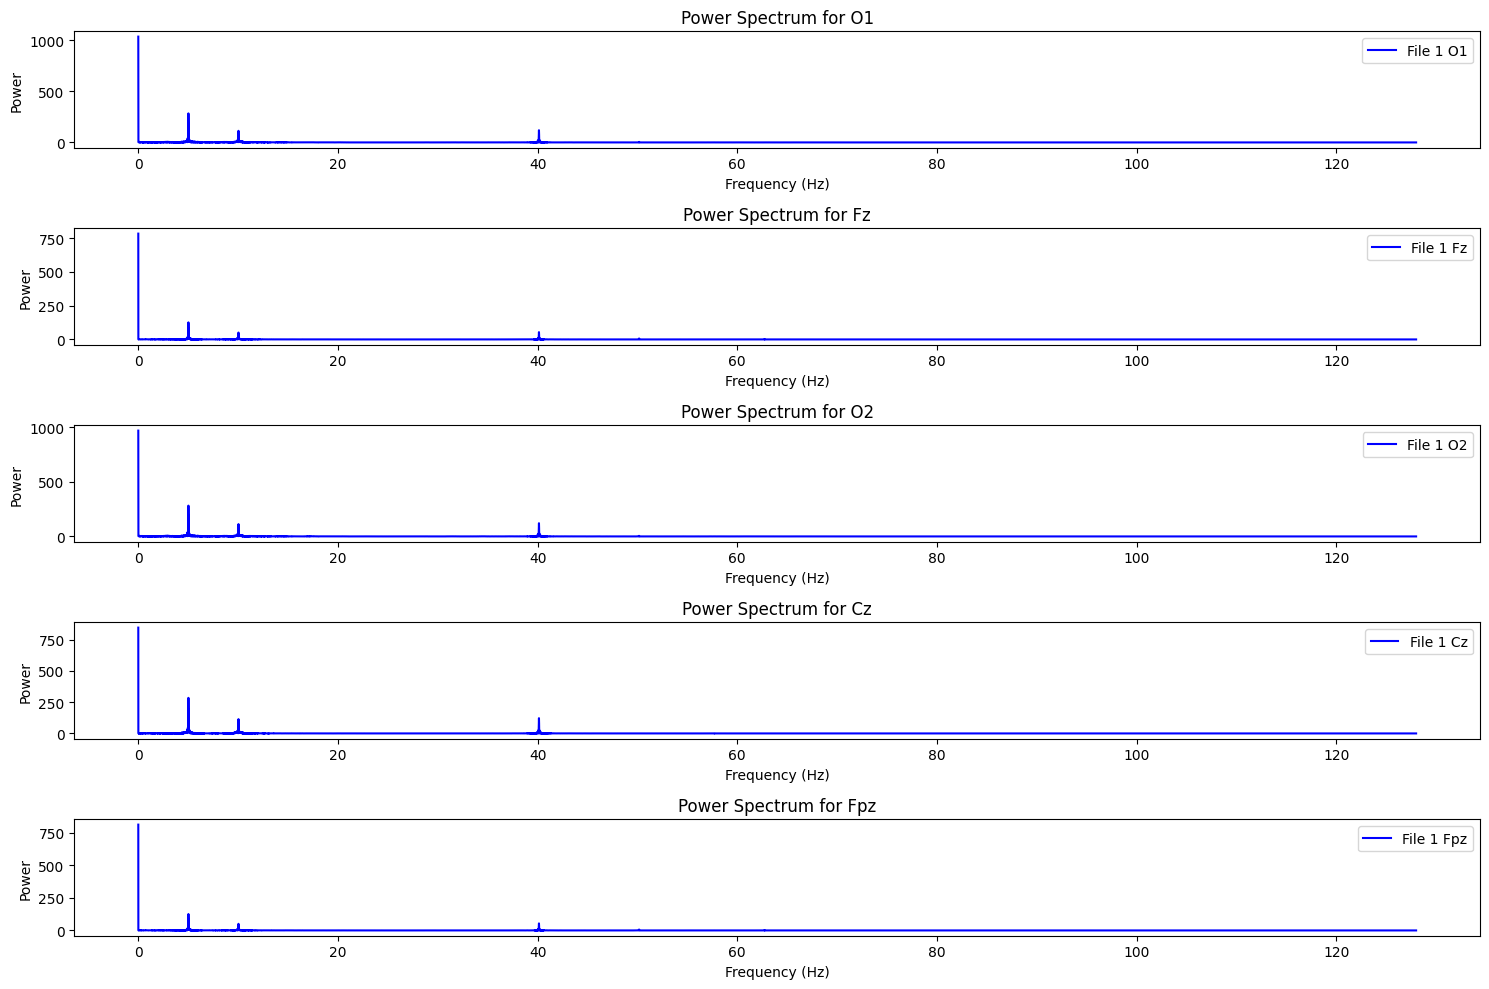

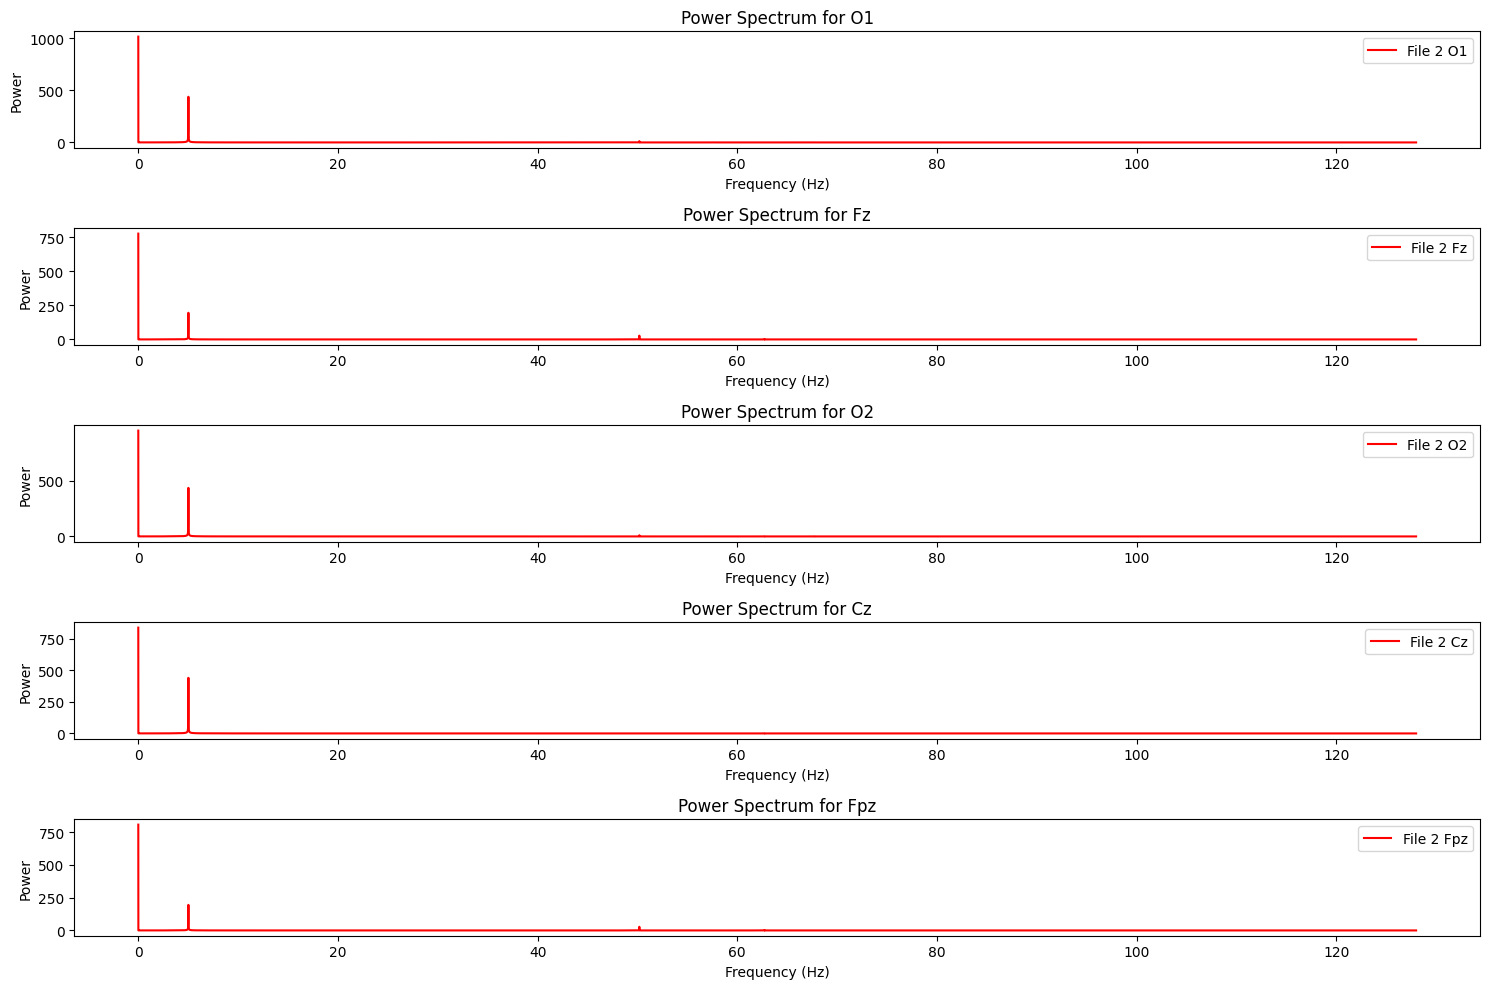

In [ ]:
from google.colab import drive
import pyxdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

# Mount Google Drive
drive.mount('/content/drive')

def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    # ค้นหา stream ชนิด 'signal' ที่ชื่อ 'eeg'
    eeg_stream = None
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
            break

    if eeg_stream is None:
        raise ValueError(f"ไม่พบ stream ชื่อ 'eeg' ในไฟล์ {filepath}")

    # ดึงข้อมูลจาก stream
    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    # สร้าง DataFrame
    df = pd.DataFrame(data, columns=channel_labels)

    return df, sampling_rate

def plot_power_spectrum(df, sampling_rate, channels, title_prefix, color='blue'):
    plt.figure(figsize=(15, 10))

    for i, channel in enumerate(channels):
        if channel in df.columns:
            # ดึงสัญญาณสำหรับช่องนี้
            signal = df[channel].values

            # คำนวณ FFT
            N = len(signal)
            T = 1.0 / sampling_rate
            yf = fft(signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]

            # คำนวณพลังงาน
            power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

            # Plot Power Spectrum
            plt.subplot(len(channels), 1, i + 1)
            plt.plot(xf, power_spectrum, color=color, label=f'{title_prefix} {channel}')
            plt.title(f'Power Spectrum for {channel}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power')
            plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()

# เลือกไฟล์ XDF จาก Google Drive
# Replace the file path below with the path to your XDF file in Google Drive
xdf_file1 = '/content/drive/MyDrive/Colab Notebooks/sub-Datatestcut_ses-SSVEP 5 HZ01_task-Default_run-001_eeg.xdf'
xdf_file2 = '/content/drive/MyDrive/Colab Notebooks/sub-Datatestcut_ses-ONLY 5 HZ_task-Default_run-001_eeg.xdf'

# โหลดข้อมูลจากไฟล์ทั้งสอง
df1, sampling_rate1 = load_data(xdf_file1)
df2, sampling_rate2 = load_data(xdf_file2)

# ช่องที่เราต้องการ plot
channels = ['O1', 'Fz', 'O2', 'Cz', 'Fpz']

# Plot สำหรับไฟล์แรก
plot_power_spectrum(df1, sampling_rate1, channels, 'File 1', color='blue')

# Plot สำหรับไฟล์ที่สอง
plot_power_spectrum(df2, sampling_rate2, channels, 'File 2', color='red')

plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


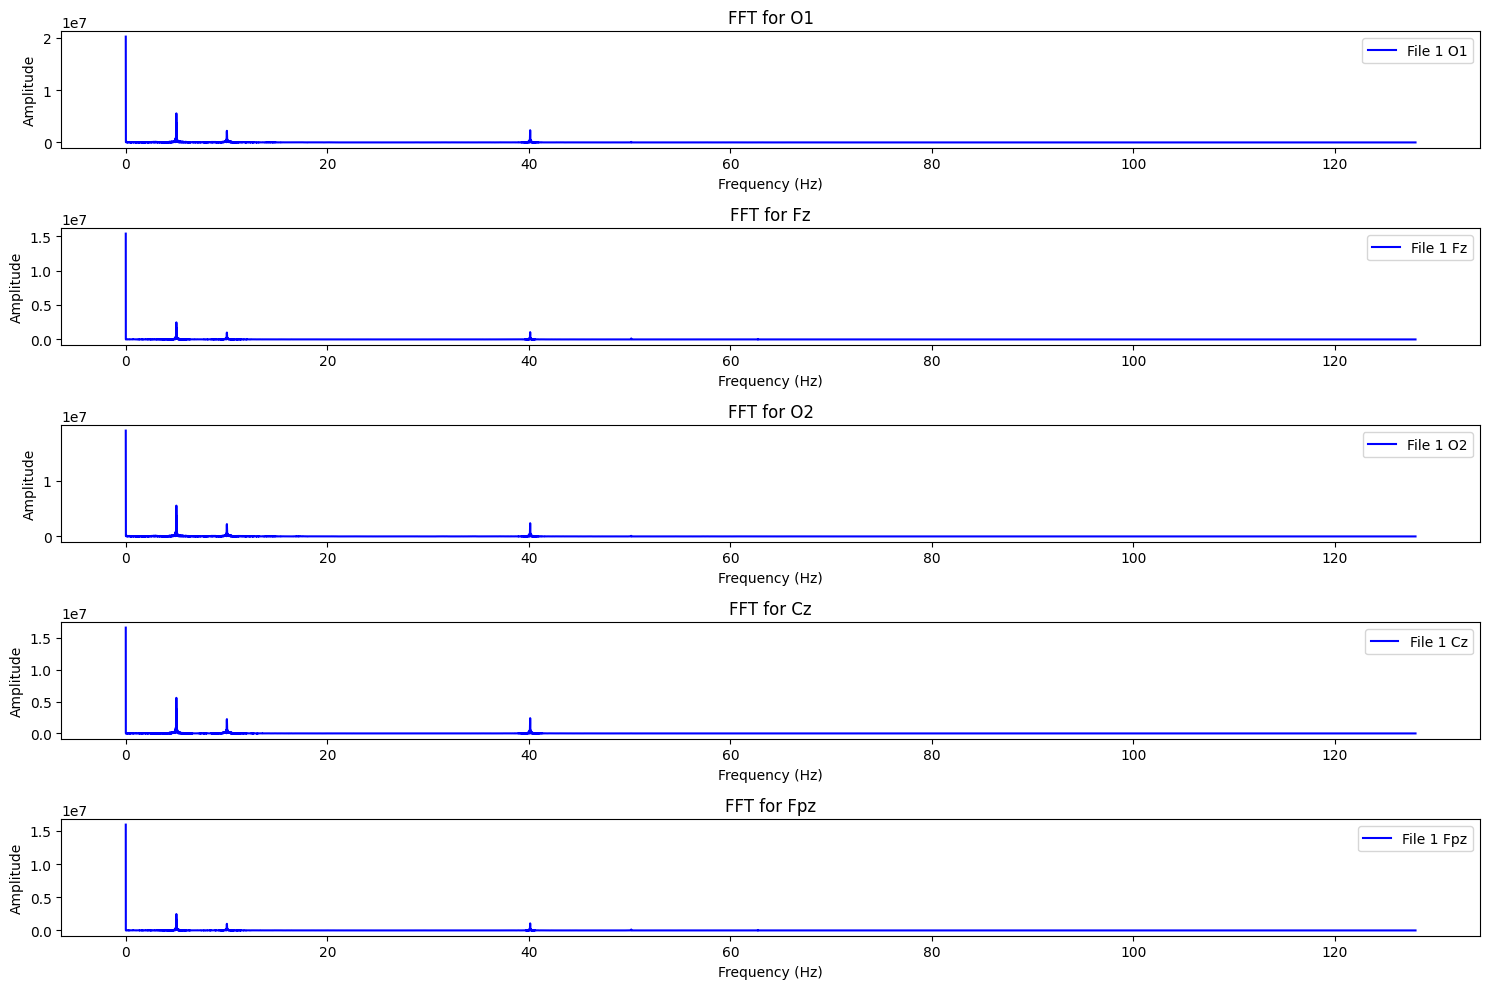

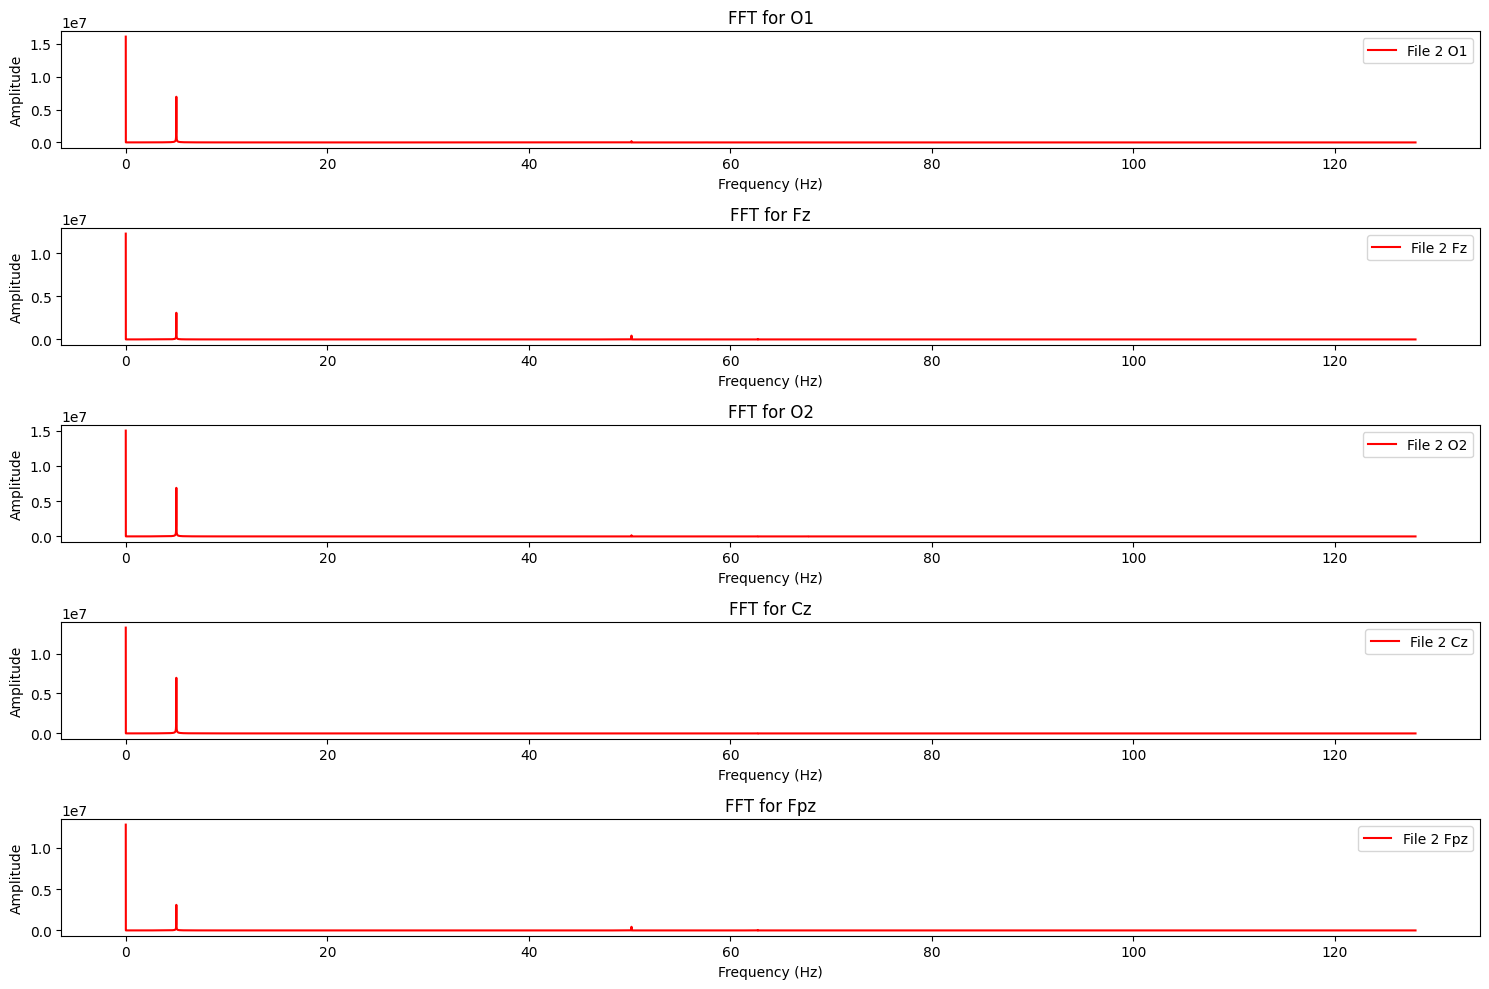

In [ ]:
from google.colab import drive
import pyxdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

# Mount Google Drive
drive.mount('/content/drive')

def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    # ค้นหา stream ชนิด 'signal' ที่ชื่อ 'eeg'
    eeg_stream = None
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
            break

    if eeg_stream is None:
        raise ValueError(f"ไม่พบ stream ชื่อ 'eeg' ในไฟล์ {filepath}")

    # ดึงข้อมูลจาก stream
    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    # สร้าง DataFrame
    df = pd.DataFrame(data, columns=channel_labels)

    return df, sampling_rate

def plot_fft(df, sampling_rate, channels, title_prefix, color='blue'):
    plt.figure(figsize=(15, 10))

    for i, channel in enumerate(channels):
        if channel in df.columns:
            # ดึงสัญญาณสำหรับช่องนี้
            signal = df[channel].values

            # คำนวณ FFT
            N = len(signal)
            T = 1.0 / sampling_rate
            yf = fft(signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]

            # Plot FFT (แสดงขนาดของค่าความถี่)
            plt.subplot(len(channels), 1, i + 1)
            plt.plot(xf, np.abs(yf[:N // 2]), color=color, label=f'{title_prefix} {channel}')
            plt.title(f'FFT for {channel}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()

# เลือกไฟล์ XDF จาก Google Drive
xdf_file1 = '/content/drive/MyDrive/Colab Notebooks/sub-Datatestcut_ses-SSVEP 5 HZ01_task-Default_run-001_eeg.xdf'
xdf_file2 = '/content/drive/MyDrive/Colab Notebooks/sub-Datatestcut_ses-ONLY 5 HZ_task-Default_run-001_eeg.xdf'

# โหลดข้อมูลจากไฟล์ทั้งสอง
df1, sampling_rate1 = load_data(xdf_file1)
df2, sampling_rate2 = load_data(xdf_file2)

# ช่องที่เราต้องการ plot
channels = ['O1', 'Fz', 'O2', 'Cz', 'Fpz']

# Plot สำหรับไฟล์แรก
plot_fft(df1, sampling_rate1, channels, 'File 1', color='blue')

# Plot สำหรับไฟล์ที่สอง
plot_fft(df2, sampling_rate2, channels, 'File 2', color='red')

plt.show()

Markers from File 1:
Timestamp: 3606.01, Marker: 4
Timestamp: 3611.82, Marker: 14
Timestamp: 3611.82, Marker: 1
Timestamp: 3632.13, Marker: 11
Timestamp: 3632.13, Marker: 4
Timestamp: 3658.64, Marker: 14
Timestamp: 3658.64, Marker: 2
Timestamp: 3686.48, Marker: 12
Timestamp: 3686.48, Marker: 4
Timestamp: 3711.00, Marker: 14
Timestamp: 3711.00, Marker: 3
Timestamp: 3771.00, Marker: 13
Timestamp: 3771.00, Marker: 4
Timestamp: 3771.33, Marker: 14
Timestamp: 3771.33, Marker: 1


<ipython-input-69-a16efe065438>:90: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


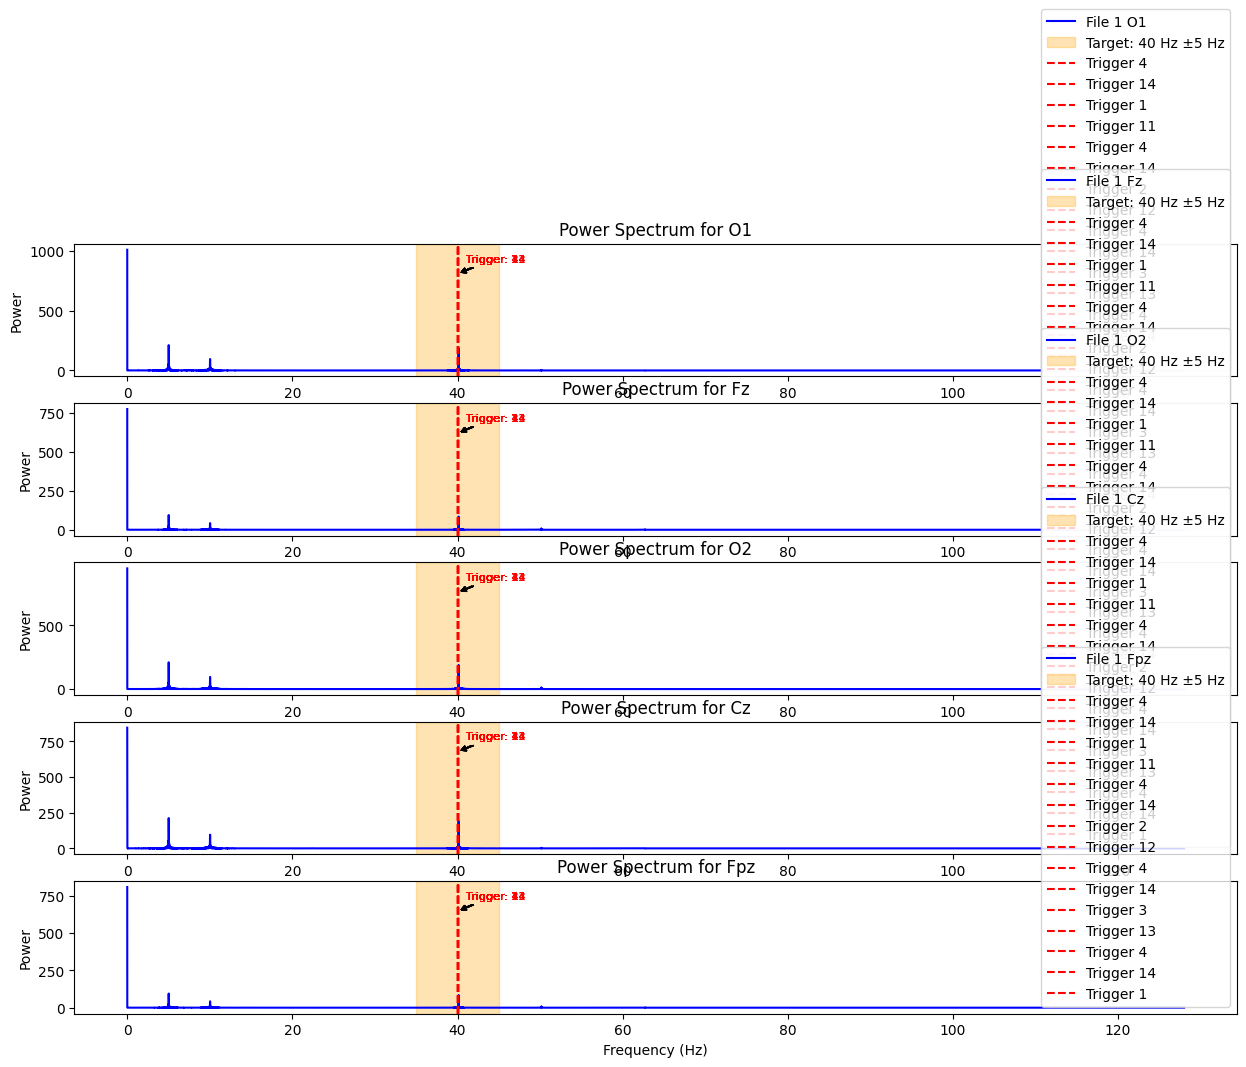

In [ ]:
import pyxdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, filtfilt

# Load data from .xdf file
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0] == 'Markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"ไม่พบ stream ชื่อ 'eeg' ในไฟล์ {filepath}")

    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    df = pd.DataFrame(data, columns=channel_labels)

    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

# Bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Plot Power Spectrum with FFT
def plot_power_spectrum_fft(df, sampling_rate, markers, channels, title_prefix, color='blue', target_freq=10, bandwidth=5):
    plt.figure(figsize=(15, 10))

    for i, channel in enumerate(channels):
        if channel in df.columns:
            signal = df[channel].values

            # FFT of the signal
            N = len(signal)
            T = 1.0 / sampling_rate
            yf = fft(signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]
            power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

            # Plot power spectrum
            plt.subplot(len(channels), 1, i + 1)
            plt.plot(xf, power_spectrum, color=color, label=f'{title_prefix} {channel}')
            plt.title(f'Power Spectrum for {channel}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power')

            # Highlight the target frequency range
            plt.axvspan(target_freq - bandwidth, target_freq + bandwidth, color='orange', alpha=0.3, label=f'Target: {target_freq} Hz ±{bandwidth} Hz')

            # Mark triggers with vertical lines in the time domain (just for reference)
            for timestamp, marker in markers:
                plt.axvline(x=target_freq, color='red', linestyle='--', label=f'Trigger {marker[0]}')
                plt.annotate(f'Trigger: {marker[0]}',
                             xy=(target_freq, max(power_spectrum) * 0.8),
                             xytext=(target_freq + 1, max(power_spectrum) * 0.9),
                             arrowprops=dict(facecolor='black', arrowstyle='->'),
                             fontsize=8,
                             color='red')

            plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()

# Load the data
df1, sampling_rate1, markers1 = load_data('/content/drive/MyDrive/Colab Notebooks/SSVEP_task-1_eeg.xdf')

# Print the markers for debugging purposes
print("Markers from File 1:")
for timestamp, marker in markers1:
    print(f"Timestamp: {timestamp:.2f}, Marker: {marker[0]}")

# Select the channels to plot
channels = ['O1', 'Fz', 'O2', 'Cz', 'Fpz']

# Plot the power spectrum using FFT for the first file
plot_power_spectrum_fft(df1, sampling_rate1, markers1, channels, 'File 1', color='blue', target_freq=40)

# Show the plot
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Markers from File 1:
Timestamp: 14329.45, Marker: 3
Timestamp: 14359.46, Marker: 13
Timestamp: 14359.46, Marker: 2
Timestamp: 14389.46, Marker: 12
Timestamp: 14389.46, Marker: 3
Timestamp: 14419.47, Marker: 13
Timestamp: 14419.47, Marker: 4
Timestamp: 14449.47, Marker: 14
Timestamp: 14449.47, Marker: 3
Timestamp: 14479.48, Marker: 13
Timestamp: 14479.48, Marker: 1
จำนวน segment ที่ถูกตัด: 0


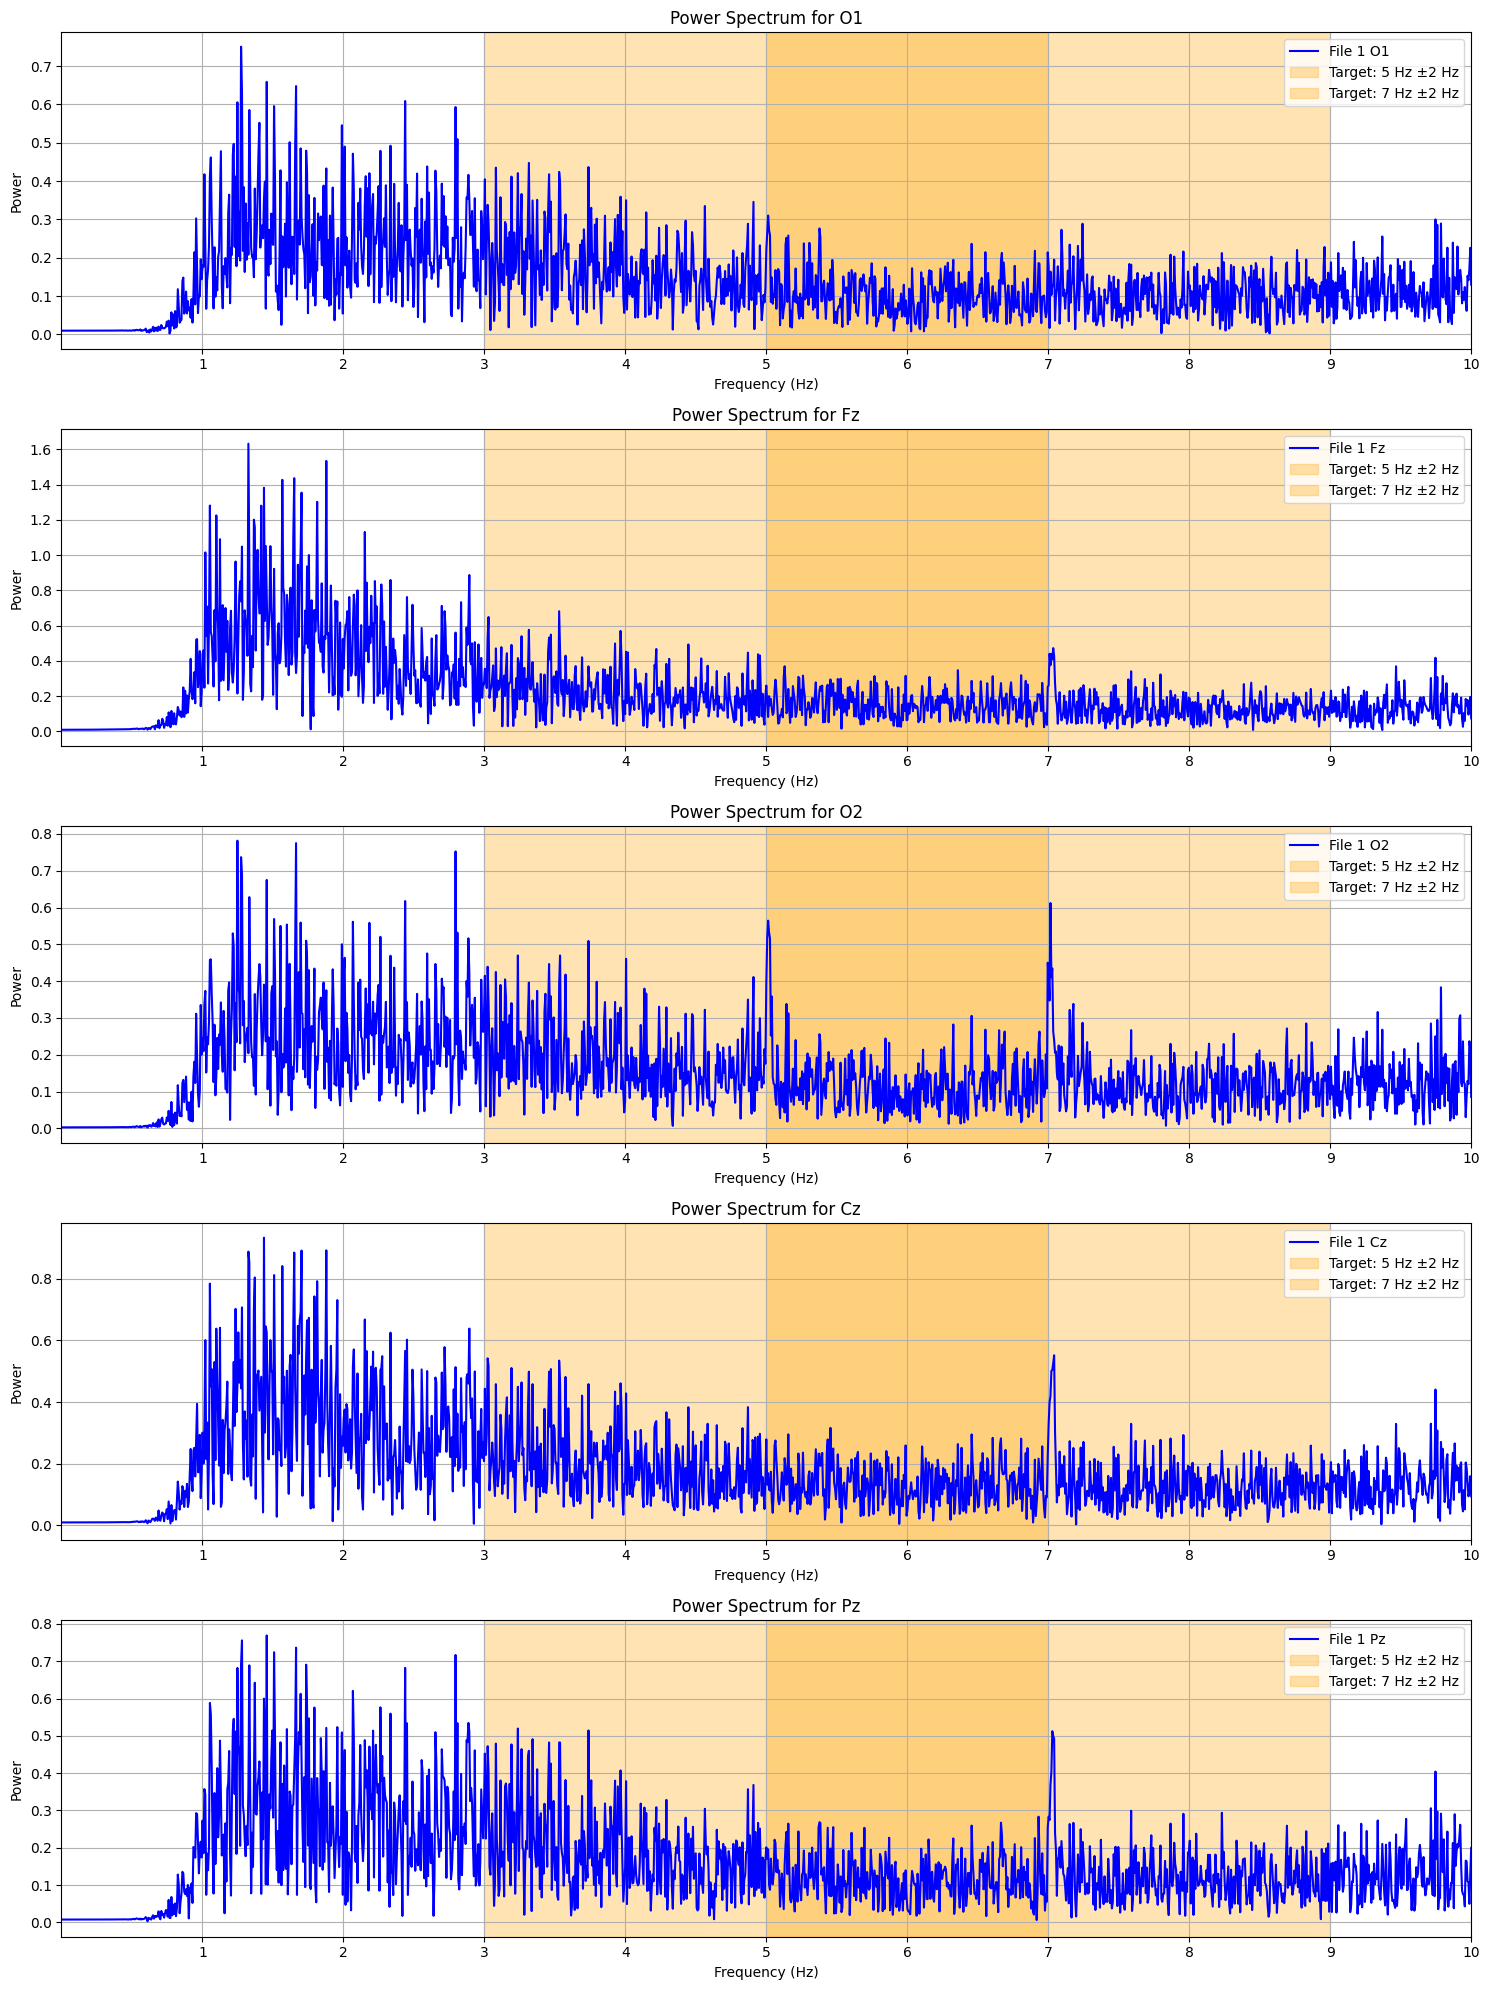

In [ ]:
import pyxdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from google.colab import drive
from scipy.fft import fft
import io

# Mount Google Drive
drive.mount('/content/drive')

# Specify the file path in Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/eeg_signal.xdf'

# Load data from .xdf file
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0] == 'Markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"ไม่พบ stream ชื่อ 'eeg' ในไฟล์ {filepath}")

    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    df = pd.DataFrame(data, columns=channel_labels)

    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

# Function for cutting EEG signal around specific markers
def cut_signal_for_selected_markers(df, sampling_rate, markers, selected_markers, pre_marker_sec=1, post_marker_sec=2):
    cut_segments = []
    for timestamp, marker in markers:
        marker_value = marker[0]

        # Check if the marker is in the selected markers list
        if marker_value in selected_markers:
            start_idx = int((timestamp - pre_marker_sec) * sampling_rate)
            end_idx = int((timestamp + post_marker_sec) * sampling_rate)

            if start_idx < 0 or end_idx > len(df):
                continue

            segment = df.iloc[start_idx:end_idx]
            cut_segments.append((segment, marker_value))

    return cut_segments

# Bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Plot power spectrum
def plot_power_spectrum(df, sampling_rate, markers, channels, title_prefix, color='blue', target_freqs=[5, 7], bandwidth=2):
    plt.figure(figsize=(15, 20))

    for i, channel in enumerate(channels):
        if channel in df.columns:
            signal = df[channel].values
            filtered_signal = bandpass_filter(signal, 1, 50, sampling_rate)

            N = len(filtered_signal)
            T = 1.0 / sampling_rate
            yf = fft(filtered_signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]
            power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

            plt.subplot(len(channels), 1, i + 1)
            plt.plot(xf, power_spectrum, color=color, label=f'{title_prefix} {channel}')
            plt.title(f'Power Spectrum for {channel}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power')
            plt.grid()
            plt.xlim(0, 10)
            plt.xticks(np.arange(1, 11, 1))

            for target_freq in target_freqs:
                plt.axvspan(target_freq - bandwidth, target_freq + bandwidth, color='orange', alpha=0.3, label=f'Target: {target_freq} Hz ±{bandwidth} Hz')

            plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()
    plt.show()

# Load data
df1, sampling_rate1, markers1 = load_data(file_path)

# Show markers
print("Markers from File 1:")
for timestamp, marker in markers1:
    print(f"Timestamp: {timestamp:.2f}, Marker: {marker[0]}")

# Define selected markers (2, 12, 4, 14)
selected_markers = [2, 12, 4, 14]

# Cut segments for the selected markers
cut_segments_selected = cut_signal_for_selected_markers(df1, sampling_rate1, markers1, selected_markers)

print(f"จำนวน segment ที่ถูกตัด: {len(cut_segments_selected)}")

# Plot power spectrum for each selected segment
channels = ['O1', 'Fz', 'O2', 'Cz', 'Pz']
plot_power_spectrum(df1, sampling_rate1, markers1, channels, 'File 1', color='blue', target_freqs=[5, 7], bandwidth=2)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Markers from File 1:
Timestamp: 14329.45, Marker: 3
Timestamp: 14359.46, Marker: 13
Timestamp: 14359.46, Marker: 2
Timestamp: 14389.46, Marker: 12
Timestamp: 14389.46, Marker: 3
Timestamp: 14419.47, Marker: 13
Timestamp: 14419.47, Marker: 4
Timestamp: 14449.47, Marker: 14
Timestamp: 14449.47, Marker: 3
Timestamp: 14479.48, Marker: 13
Timestamp: 14479.48, Marker: 1
จำนวน segment ที่ถูกตัด: 0


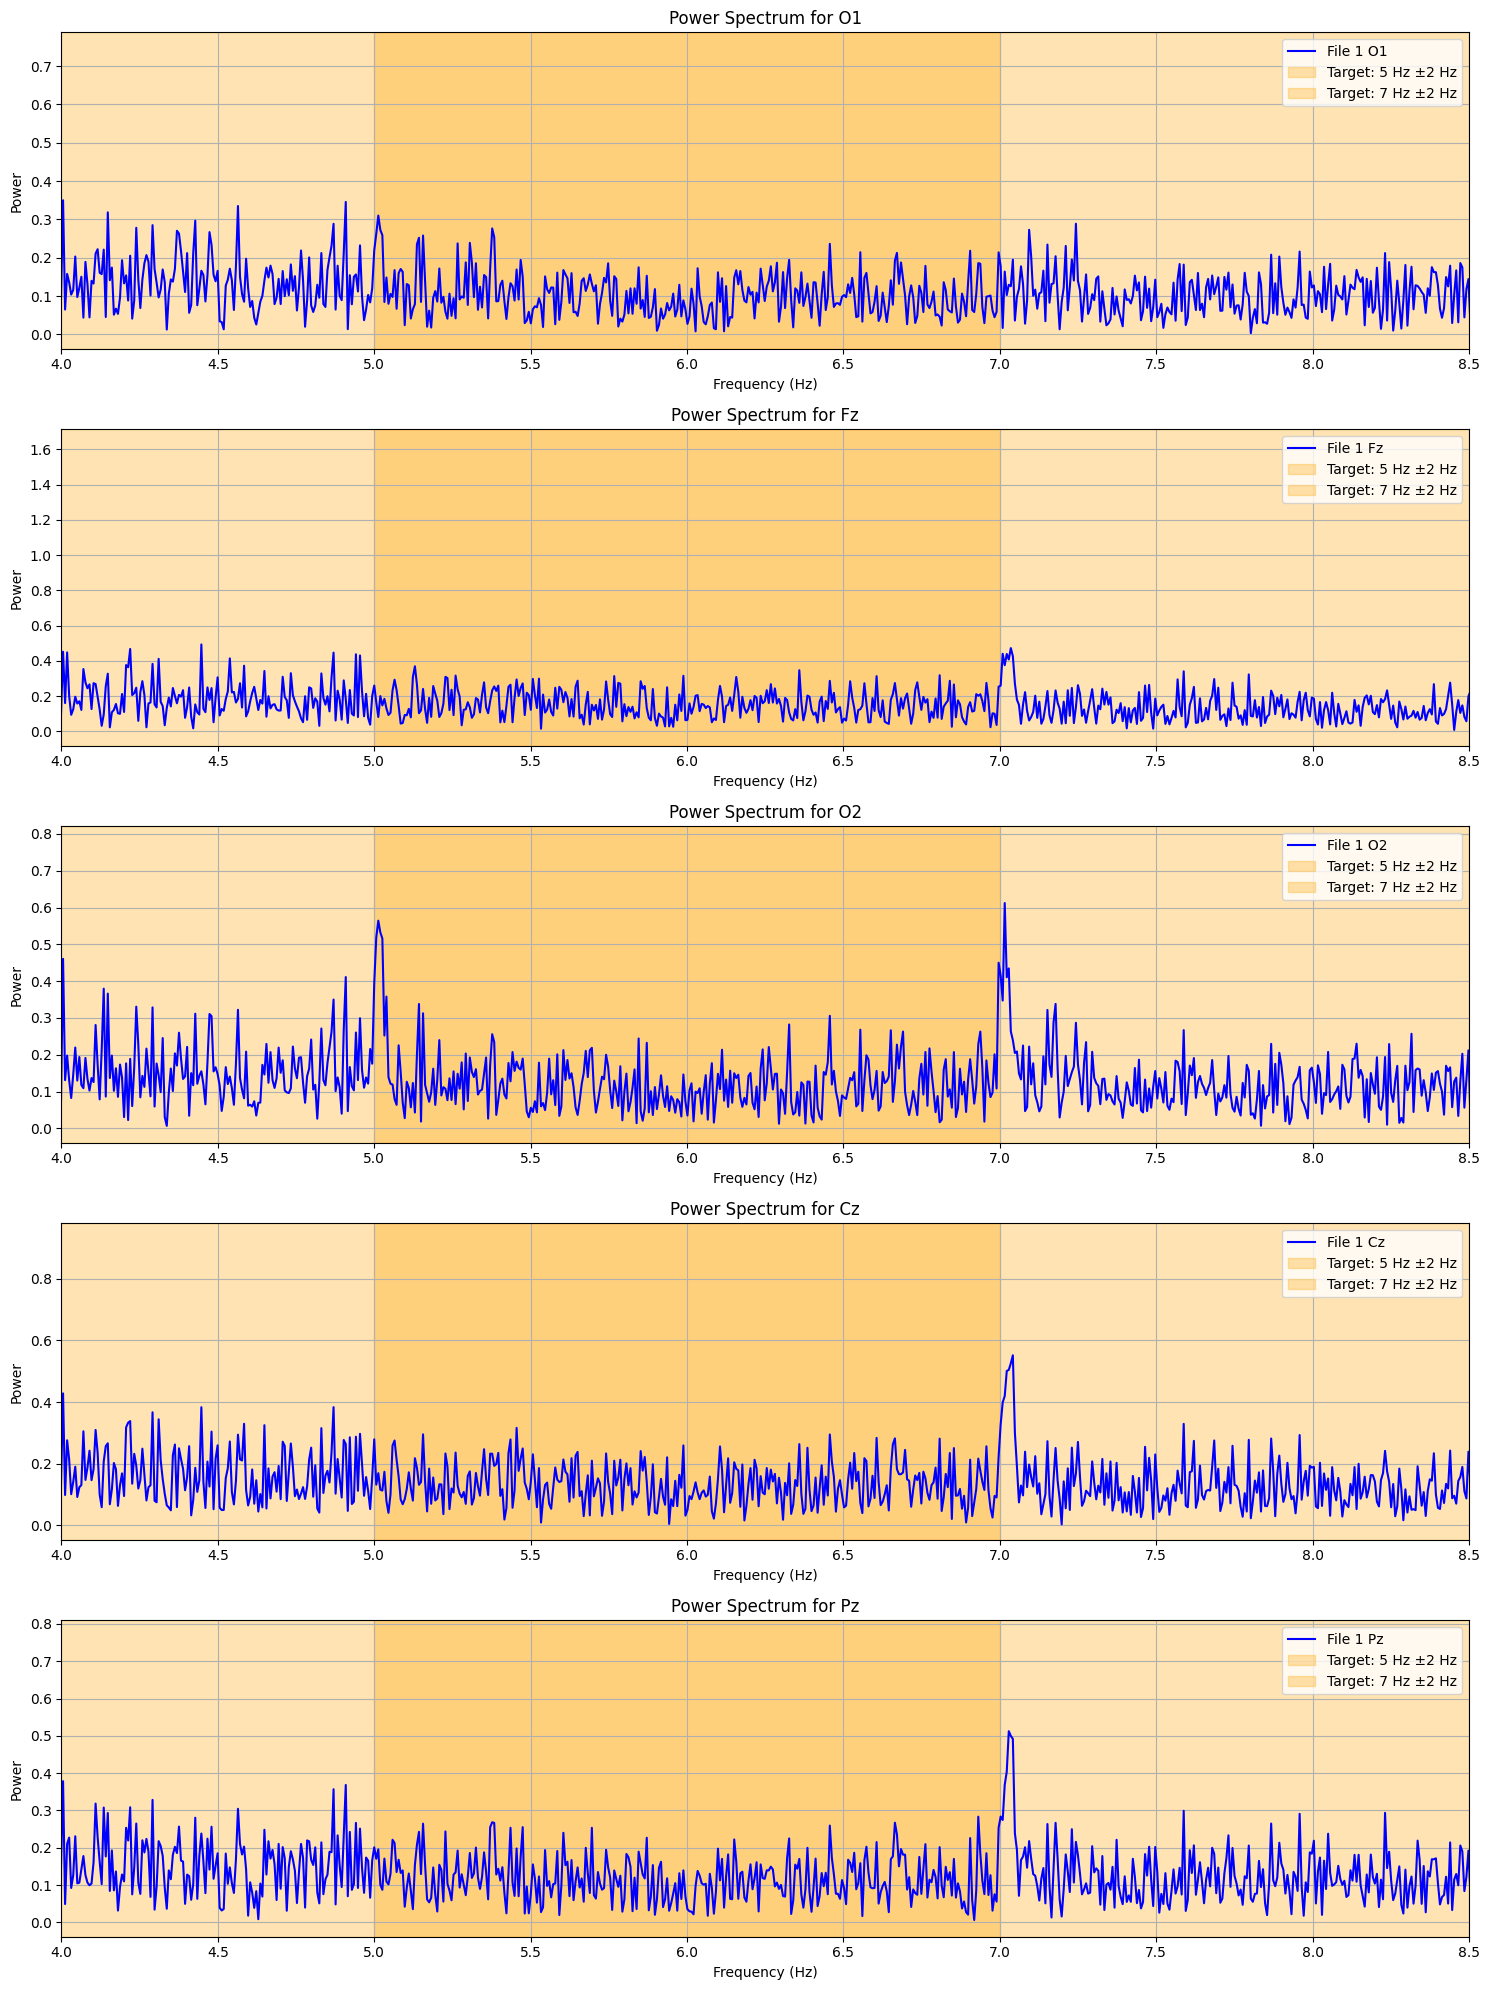

In [ ]:
import pyxdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from google.colab import drive
from scipy.fft import fft
import io

# Mount Google Drive
drive.mount('/content/drive')

# Specify the file path in Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/eeg_signal.xdf'

# Load data from .xdf file
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0] == 'Markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"ไม่พบ stream ชื่อ 'eeg' ในไฟล์ {filepath}")

    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    df = pd.DataFrame(data, columns=channel_labels)

    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

# Function for cutting EEG signal around specific markers
def cut_signal_for_selected_markers(df, sampling_rate, markers, selected_markers, pre_marker_sec=1, post_marker_sec=2):
    cut_segments = []
    for timestamp, marker in markers:
        marker_value = marker[0]

        # Check if the marker is in the selected markers list
        if marker_value in selected_markers:
            start_idx = int((timestamp - pre_marker_sec) * sampling_rate)
            end_idx = int((timestamp + post_marker_sec) * sampling_rate)

            if start_idx < 0 or end_idx > len(df):
                continue

            segment = df.iloc[start_idx:end_idx]
            cut_segments.append((segment, marker_value))

    return cut_segments

# Bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Plot power spectrum with a focus on 5-7 Hz
def plot_power_spectrum(df, sampling_rate, markers, channels, title_prefix, color='blue', target_freqs=[5, 7], bandwidth=2):
    plt.figure(figsize=(15, 20))

    for i, channel in enumerate(channels):
        if channel in df.columns:
            signal = df[channel].values
            filtered_signal = bandpass_filter(signal, 1, 50, sampling_rate)

            N = len(filtered_signal)
            T = 1.0 / sampling_rate
            yf = fft(filtered_signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]
            power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

            plt.subplot(len(channels), 1, i + 1)
            plt.plot(xf, power_spectrum, color=color, label=f'{title_prefix} {channel}')
            plt.title(f'Power Spectrum for {channel}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power')
            plt.grid()

            # Focus the x-axis on the 5 to 7 Hz range
            plt.xlim(4, 8)
            plt.xticks(np.arange(4, 9, 0.5))

            # Highlight the target frequency bands
            for target_freq in target_freqs:
                plt.axvspan(target_freq - bandwidth, target_freq + bandwidth, color='orange', alpha=0.3, label=f'Target: {target_freq} Hz ±{bandwidth} Hz')

            plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()
    plt.show()

# Load data
df1, sampling_rate1, markers1 = load_data(file_path)

# Show markers
print("Markers from File 1:")
for timestamp, marker in markers1:
    print(f"Timestamp: {timestamp:.2f}, Marker: {marker[0]}")

# Define selected markers (2, 12, 4, 14)
selected_markers = [2, 12, 4, 14]

# Cut segments for the selected markers
cut_segments_selected = cut_signal_for_selected_markers(df1, sampling_rate1, markers1, selected_markers)

print(f"จำนวน segment ที่ถูกตัด: {len(cut_segments_selected)}")

# Plot power spectrum for each selected segment
channels = ['O1', 'Fz', 'O2', 'Cz', 'Pz']
plot_power_spectrum(df1, sampling_rate1, markers1, channels, 'File 1', color='blue', target_freqs=[5, 7], bandwidth=2)

In [ ]:
# Install required packages
!pip install mne pyxdf

import pyxdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from google.colab import files
from scipy.fft import fft
%matplotlib inline

# Upload file
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Function to load data from an .xdf file
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0] == 'Markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"Cannot find 'eeg' stream in file {filepath}")

    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    df = pd.DataFrame(data, columns=channel_labels)

    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

# Load EEG data and markers
df, sampling_rate, markers = load_data(file_name)

# Define marker triggers for SSVEP
ssvep_5hz_trigger_start = 2
ssvep_5hz_trigger_end = 12
ssvep_7hz_trigger_start = 4
ssvep_7hz_trigger_end = 14

# Function to cut EEG signal based on markers
def cut_ssvep_signal(eeg_data, markers, start_trigger, end_trigger, pre_time=1, post_time=2, fs=256):
    segments = []
    for i in range(len(markers) - 1):
        if markers[i][0] == start_trigger and markers[i + 1][0] == end_trigger:
            start = int((markers[i][0] - pre_time) * fs)
            end = int((markers[i + 1][0] + post_time) * fs)
            if start >= 0 and end <= len(eeg_data):
                segment = eeg_data[start:end]
                segments.append(segment)
            else:
                print(f"Warning: Segment indices out of bounds for markers at {markers[i][0]} and {markers[i + 1][0]}.")
    return segments

# Cut EEG segments for SSVEP 5 Hz and 7 Hz
eeg_segments_5hz = cut_ssvep_signal(df.values, markers, ssvep_5hz_trigger_start, ssvep_5hz_trigger_end)
eeg_segments_7hz = cut_ssvep_signal(df.values, markers, ssvep_7hz_trigger_start, ssvep_7hz_trigger_end)

# Bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Plot power spectrum for selected channels
def plot_power_spectrum(df, sampling_rate, channels, title_prefix, color='blue', target_freqs=[5, 7], bandwidth=2):
    plt.figure(figsize=(15, 20))

    for i, channel in enumerate(channels):
        if channel in df.columns:
            signal = df[channel].values
            filtered_signal = bandpass_filter(signal, 1, 50, sampling_rate)

            N = len(filtered_signal)
            T = 1.0 / sampling_rate
            yf = fft(filtered_signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]
            power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

            plt.subplot(len(channels), 1, i + 1)
            plt.plot(xf, power_spectrum, color=color, label=f'{title_prefix} {channel}')
            plt.title(f'Power Spectrum for {channel}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power')
            plt.grid()
            plt.xlim(0, 10)
            plt.xticks(np.arange(1, 11, 1))

            for target_freq in target_freqs:
                plt.axvspan(target_freq - bandwidth, target_freq + bandwidth, color='orange', alpha=0.3, label=f'Target: {target_freq} Hz ±{bandwidth} Hz')

            plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()
    plt.show()

# Define channels for analysis
channels = ['O1', 'Fz', 'O2', 'Cz', 'Pz']

# Plot power spectrum for each selected segment
for i, segment in enumerate(eeg_segments_5hz + eeg_segments_7hz):
    df_segment = pd.DataFrame(segment, columns=channels)  # Create DataFrame from the segment
    plot_power_spectrum(df_segment, sampling_rate, channels, f'SSVEP Segment {i + 1}', color='blue', target_freqs=[5, 7], bandwidth=2)
plt.show()
print(f'Number of 5 Hz segments: {len(eeg_segments_5hz)}')
print(f'Number of 7 Hz segments: {len(eeg_segments_7hz)}')

# Plot power spectrum for each selected segment
for i, segment in enumerate(eeg_segments_5hz + eeg_segments_7hz):
    df_segment = pd.DataFrame(segment, columns=channels)  # Create DataFrame from the segment
    plot_power_spectrum(df_segment, sampling_rate, channels, f'SSVEP Segment {i + 1}', color='blue', target_freqs=[5, 7], bandwidth=2)
    plt.show()  # แสดงกราฟหลังจากแต่ละส่วน

plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 87.2 MB/s eta 0:00:00


KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Markers: [(14329.452032527886, array([3], dtype=int32)), (14359.455491683912, array([13], dtype=int32)), (14359.45556908357, array([2], dtype=int32)), (14389.463451623451, array([12], dtype=int32)), (14389.463530223118, array([3], dtype=int32)), (14419.465005586622, array([13], dtype=int32)), (14419.46510648611, array([4], dtype=int32)), (14449.472949326038, array([14], dtype=int32)), (14449.47302762582, array([3], dtype=int32)), (14479.48274535872, array([13], dtype=int32))]


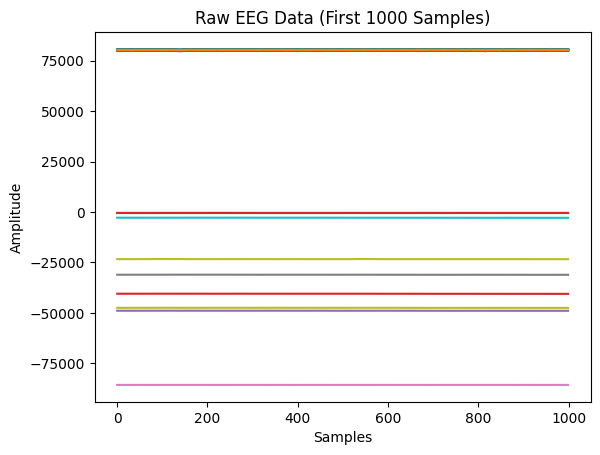

Number of 5 Hz segments: 0
Number of 7 Hz segments: 0


In [ ]:
import pyxdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from google.colab import drive
from scipy.fft import fft

# Mount Google Drive
drive.mount('/content/drive')

# Set file path (update with your actual file path in Google Drive)
file_path = '/content/drive/MyDrive/Colab Notebooks/eeg_signal.xdf'  # Change this to your file path

# ฟังก์ชันสำหรับโหลดข้อมูลจากไฟล์ .xdf
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0] == 'Markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"ไม่พบ stream ชื่อ 'eeg' ในไฟล์ {filepath}")

    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    df = pd.DataFrame(data, columns=channel_labels)

    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))  # Combine times and values

    return df, sampling_rate, markers

# โหลดข้อมูลจากไฟล์ XDF จาก Google Drive
df, sampling_rate, markers = load_data(file_path)

# Debug: Print marker information
print("Markers:", markers[:10])  # Print the first 10 markers to verify

# Define the start and end triggers for SSVEP
ssvep_5hz_trigger_start = '2'  # Start trigger for SSVEP 5 Hz (as a string if markers are strings)
ssvep_5hz_trigger_end = '12'   # End trigger for SSVEP 5 Hz
ssvep_7hz_trigger_start = '4'  # Start trigger for SSVEP 7 Hz
ssvep_7hz_trigger_end = '14'   # End trigger for SSVEP 7 Hz

# ฟังก์ชันในการตัดสัญญาณ EEG
def cut_ssvep_signal(eeg_data, markers, start_trigger, end_trigger, pre_time=1, post_time=2, fs=256):
    segments = []
    for i in range(len(markers) - 1):
        # Ensure marker values are properly compared as strings
        if markers[i][1][0] == start_trigger and markers[i + 1][1][0] == end_trigger:
            # Convert time stamps to sample indices
            start = int((markers[i][0] - pre_time) * fs)  # Start time in samples
            end = int((markers[i + 1][0] + post_time) * fs)  # End time in samples
            segment = eeg_data[start:end]  # Extract the EEG segment
            segments.append(segment)
    return segments

# Test if EEG data and markers are loaded correctly by plotting some raw EEG data
plt.figure()
plt.plot(df.iloc[:1000])  # Plot the first 1000 samples for visual inspection
plt.title("Raw EEG Data (First 1000 Samples)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

# ตัดสัญญาณ EEG สำหรับ SSVEP 5 Hz
eeg_segments_5hz = cut_ssvep_signal(df.values, markers, ssvep_5hz_trigger_start, ssvep_5hz_trigger_end)

# ตัดสัญญาณ EEG สำหรับ SSVEP 7 Hz
eeg_segments_7hz = cut_ssvep_signal(df.values, markers, ssvep_7hz_trigger_start, ssvep_7hz_trigger_end)

# Debug: Print the length of the segments to ensure they're being extracted
print(f"Number of 5 Hz segments: {len(eeg_segments_5hz)}")
print(f"Number of 7 Hz segments: {len(eeg_segments_7hz)}")

# แสดงผลกราฟ SSVEP 5 Hz
for i, segment in enumerate(eeg_segments_5hz):
    plt.figure()
    plt.plot(segment)
    plt.title(f'EEG Segment for SSVEP 5 Hz ({i + 1})')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()

# แสดงผลกราฟ SSVEP 7 Hz
for i, segment in enumerate(eeg_segments_7hz):
    plt.figure()
    plt.plot(segment)
    plt.title(f'EEG Segment for SSVEP 7 Hz ({i + 1})')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()


In [ ]:
import pyxdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, filtfilt
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to your .xdf file in Google Drive (change the folder path accordingly)
file_path = '/content/drive/MyDrive/Colab Notebooks/eeg_signal.xdf'

# Function to load data from the .xdf file
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0] == 'Markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"ไม่พบ stream ชื่อ 'eeg' ในไฟล์ {filepath}")

    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    df = pd.DataFrame(data, columns=channel_labels)

    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

# Function to extract segment based on timestamp
def extract_segment_by_timestamp(df, markers, sampling_rate, target_timestamp, duration=5):
    segment = None
    for timestamp, marker in markers:
        if abs(timestamp - target_timestamp) < 0.1:
            start_time = timestamp
            end_time = timestamp + duration
            segment = df[(df.index / sampling_rate >= start_time) & (df.index / sampling_rate < end_time)]
            break
    return segment

# Bandpass filter functions
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Plot Power Spectrum using FFT
def plot_power_spectrum_fft(df, sampling_rate, markers, channels, title_prefix, color='blue', target_freqs=[5, 7], bandwidth=2):
    plt.figure(figsize=(15, 20))

    for i, channel in enumerate(channels):
        if channel in df.columns:
            signal = df[channel].values

            # Apply bandpass filter
            filtered_signal = bandpass_filter(signal, 1, 50, sampling_rate)

            # FFT of the filtered signal
            N = len(filtered_signal)
            T = 1.0 / sampling_rate
            yf = fft(filtered_signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]
            power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

            # Plot power spectrum
            plt.subplot(len(channels), 1, i + 1)
            plt.plot(xf, power_spectrum, color=color, label=f'{title_prefix} {channel}')
            plt.title(f'Power Spectrum for {channel}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power')

            # Set frequency range to 0-10 Hz
            plt.xlim(0, 10)

            # Highlight the target frequency ranges (5 Hz and 7 Hz)
            for target_freq in target_freqs:
                plt.axvspan(target_freq - bandwidth, target_freq + bandwidth, color='orange', alpha=0.3)

            # Mark triggers with vertical lines in the frequency domain
            for timestamp, marker in markers:
                plt.axvline(x=timestamp, color='red', linestyle='--', label=f'Trigger {marker[0]}')

            plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()

# Load data from the file in Google Drive
df1, sampling_rate1, markers1 = load_data(file_path)

# Display markers for verification
print("Markers from File 1:")
for timestamp, marker in markers1:
    print(f"Timestamp: {timestamp:.2f}, Marker: {marker[0]}")

# Check available timestamps in DataFrame
print("ช่วงเวลาที่มีอยู่ใน DataFrame:")
timestamps = df1.index / sampling_rate1
print(timestamps)

# Ask the user to select a timestamp from calculated values
print("\nกรุณาเลือก Timestamp ที่ต้องการ:")
valid_timestamps = [timestamp for timestamp in timestamps if any(abs(marker[0] - timestamp) < 0.1 for marker in markers1)]
for i, timestamp in enumerate(valid_timestamps):
    print(f"{i}: {timestamp:.2f}")

# User selects the timestamp
selected_index = int(input("กรุณาใส่หมายเลขที่ต้องการ: "))
target_timestamp = valid_timestamps[selected_index]

# Extract the segment matching the selected timestamp
segment = extract_segment_by_timestamp(df1, markers1, sampling_rate1, target_timestamp)

# Display the extracted segment and plot the power spectrum
if segment is not None and not segment.empty:
    print(f"ช่วงข้อมูลที่ Timestamp {target_timestamp:.2f}:")
    print(segment)

    # Plot the power spectrum for the selected segment
    plot_power_spectrum_fft(segment, sampling_rate1, markers1, ['O1', 'Fz', 'O2', 'Cz', 'Pz'], f'ช่วงที่ Timestamp {target_timestamp:.2f}', color='blue')
else:
    print(f"ไม่พบข้อมูลที่ Timestamp {target_timestamp:.2f}.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Markers from File 1:
Timestamp: 14329.45, Marker: 3
Timestamp: 14359.46, Marker: 13
Timestamp: 14359.46, Marker: 2
Timestamp: 14389.46, Marker: 12
Timestamp: 14389.46, Marker: 3
Timestamp: 14419.47, Marker: 13
Timestamp: 14419.47, Marker: 4
Timestamp: 14449.47, Marker: 14
Timestamp: 14449.47, Marker: 3
Timestamp: 14479.48, Marker: 13
Timestamp: 14479.48, Marker: 1
ช่วงเวลาที่มีอยู่ใน DataFrame:
Index([         0.0,   0.00390625,    0.0078125,   0.01171875,     0.015625,
         0.01953125,    0.0234375,   0.02734375,      0.03125,   0.03515625,
       ...
        153.7578125, 153.76171875,   153.765625, 153.76953125,  153.7734375,
       153.77734375,    153.78125, 153.78515625,  153.7890625, 153.79296875],
      dtype='float64', length=39372)

กรุณาเลือก Timestamp ที่ต้องการ:
กรุณาใส่หมายเลขที่ต้องการ: 14419.47


ValueError: invalid literal for int() with base 10: '14419.47'

In [ ]:
import pyxdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, filtfilt
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to your .xdf file in Google Drive (change the folder path accordingly)
file_path = '/content/drive/MyDrive/Colab Notebooks/eeg_signal.xdf'

# Function to load data from the .xdf file
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0] == 'Markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"ไม่พบ stream ชื่อ 'eeg' ในไฟล์ {filepath}")

    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    df = pd.DataFrame(data, columns=channel_labels)

    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

# Function to extract segment based on marker timestamp
def extract_segment_by_marker(df, markers, sampling_rate, marker_value, duration=5):
    segment = None
    for timestamp, marker in markers:
        if marker[0] == marker_value:  # Match the marker value
            start_time = timestamp
            end_time = timestamp + duration
            segment = df[(df.index / sampling_rate >= start_time) & (df.index / sampling_rate < end_time)]
            break
    return segment

# Bandpass filter functions
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Plot Power Spectrum using FFT
def plot_power_spectrum_fft(df, sampling_rate, markers, channels, title_prefix, color='blue', target_freqs=[5, 7], bandwidth=2):
    plt.figure(figsize=(15, 20))

    for i, channel in enumerate(channels):
        if channel in df.columns:
            signal = df[channel].values

            # Apply bandpass filter
            filtered_signal = bandpass_filter(signal, 1, 50, sampling_rate)

            # FFT of the filtered signal
            N = len(filtered_signal)
            T = 1.0 / sampling_rate
            yf = fft(filtered_signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]
            power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

            # Plot power spectrum
            plt.subplot(len(channels), 1, i + 1)
            plt.plot(xf, power_spectrum, color=color, label=f'{title_prefix} {channel}')
            plt.title(f'Power Spectrum for {channel}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power')

            # Set frequency range to 0-10 Hz
            plt.xlim(0, 10)

            # Highlight the target frequency ranges (5 Hz and 7 Hz)
            for target_freq in target_freqs:
                plt.axvspan(target_freq - bandwidth, target_freq + bandwidth, color='orange', alpha=0.3)

            # Mark triggers with vertical lines in the frequency domain
            for timestamp, marker in markers:
                plt.axvline(x=timestamp, color='red', linestyle='--', label=f'Trigger {marker[0]}')

            plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()

# Load data from the file in Google Drive
df1, sampling_rate1, markers1 = load_data(file_path)

# Display available marker values for selection
print("Markers from File 1:")
unique_markers = list(set(marker[0] for _, marker in markers1))  # Unique marker values
for i, marker_value in enumerate(unique_markers):
    print(f"{i}: Marker Value {marker_value}")

# Ask the user to select a marker value
try:
    selected_marker_index = int(input("กรุณาใส่หมายเลขที่ต้องการเลือก Marker: "))
    selected_marker_value = unique_markers[selected_marker_index]

    # Extract the segment corresponding to the selected marker
    segment = extract_segment_by_marker(df1, markers1, sampling_rate1, selected_marker_value)

    # Display the extracted segment and plot the power spectrum
    if segment is not None and not segment.empty:
        print(f"ช่วงข้อมูลที่ Marker '{selected_marker_value}':")
        print(segment)

        # Plot the power spectrum for the selected segment
        plot_power_spectrum_fft(segment, sampling_rate1, markers1, ['O1', 'Fz', 'O2', 'Cz', 'Pz'], f'Marker {selected_marker_value}', color='blue')
    else:
        print(f"ไม่พบข้อมูลที่ Marker '{selected_marker_value}'.")
except (ValueError, IndexError) as e:
    print(f"Error: {e}. กรุณาใส่หมายเลขที่ถูกต้อง.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Markers from File 1:
0: Marker Value 1
1: Marker Value 2
2: Marker Value 3
3: Marker Value 4
4: Marker Value 12
5: Marker Value 13
6: Marker Value 14
